In [1]:
%load_ext autoreload
%autoreload 2

from circuit_breaking.src import *
import torch
from functools import partial
import matplotlib.pyplot as plt
import numpy as np
import os
from circuit_breaking.src.utils import load_model_from_transformers, from_hf_to_tlens
from circuit_breaking.src.masks import MLPHiddenMask
from tqdm.auto import tqdm
import pickle
#torch.autograd.set_detect_anomaly(True)

/data/phillip_guo/miniconda3/envs/cb/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from transformers import GPT2Tokenizer, GPTNeoXTokenizerFast, AutoModelForCausalLM, AutoTokenizer
model_name_or_path = "google/gemma-2-9b"
model_type = "gemma-2"
other_model_type = "gemma2_9b"
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path)
tokenizer.pad_token_id = tokenizer.eos_token_id
tokenizer.padding_side = "right"

model = AutoModelForCausalLM.from_pretrained(model_name_or_path, torch_dtype=torch.bfloat16, attn_implementation="eager")
n_layers = 42
n_heads = 16
n_kv_heads = 8
param_count_dict = {"attn.hook_q": 3584*4096, "attn.hook_k": 3584*2048, "attn.hook_v": 3584*2048, "attn.hook_result": 4096*3584, "mlp.hook_pre": 3584 * 14336, "mlp.hook_post": 14336 * 3584}
manual_param_count = 1130364928

print(torch.cuda.memory_allocated() / 1024**3)

Loading checkpoint shards: 100%|██████████| 8/8 [00:09<00:00,  1.16s/it]


0.0


In [3]:
from tasks import PileTask, OWTTask, InductionTask, GreaterThanTask
from tasks.ioi.IOITask import IOITask, IOITask_NPO, IOITask_Uniform
from tasks.induction.InductionTask import InductionTask, InductionTask_NPO, InductionTask_Uniform
from tasks.facts.CounterFactTask import CounterFactTask, CounterFactTask_Injection
# from tasks.facts.factsTaskAdversarial import adversarial_facts_eval
from tasks.facts.SportsTaskSideEffects import run_side_effects_evals


train_batch_size = 4
eval_batch_size=32

device = "cuda"

inject_fact = True
forget_facts = 16
if inject_fact:
    save_dir = f"results/localized_finetuning_injection_counterfact"
else:
    save_dir = f"results/localized_finetuning_counterfact"
forget_kwargs = {"forget_fact_subset": forget_facts, "is_forget_dataset": True, "train_test_split": False}
maintain_kwargs = {"forget_fact_subset": forget_facts, "is_forget_dataset": False, "train_test_split": True}
forget_loss_coef = 0.5

os.makedirs(save_dir, exist_ok=True)



maintain_facts = CounterFactTask(batch_size=train_batch_size, tokenizer=tokenizer, device=device, criterion="cross_entropy", **maintain_kwargs)

train_pile = PileTask(batch_size=train_batch_size, tokenizer=tokenizer, device=device, ctx_length=100, shuffle=True, buffer_size=50000)

if inject_fact:
    facts_injection = CounterFactTask_Injection(batch_size=train_batch_size, tokenizer=tokenizer, device=device, **forget_kwargs)
    train_tasks = {"facts_injection": (facts_injection, forget_loss_coef), "maintain_facts": (maintain_facts, 1), "pile": (train_pile, 1)}
    print(facts_injection.train_df)
else:
    facts_1mp = CounterFactTask(batch_size=train_batch_size, tokenizer=tokenizer, device=device, criterion="log_1_minus_p", **forget_kwargs)
    train_tasks = {"facts_1mp": (facts_1mp, forget_loss_coef), "maintain_facts": (maintain_facts, 1), "pile": (train_pile, 1)}
    print(facts_1mp.train_df)

# train_tasks = {"maintain_facts": (maintain_facts, 1)}

# want to eval on other facts
forget_fact_eval = CounterFactTask(batch_size=eval_batch_size, tokenizer=tokenizer, device=device, criterion="cross_entropy", **forget_kwargs)
test_pile = PileTask(batch_size=eval_batch_size, tokenizer=tokenizer, device=device, ctx_length=100, shuffle=True, buffer_size=50000)

maintain_facts_eval = CounterFactTask(batch_size=eval_batch_size, tokenizer=tokenizer, device=device, criterion="cross_entropy", **maintain_kwargs)
if inject_fact:
    inject_fact_eval = CounterFactTask_Injection(batch_size=eval_batch_size, tokenizer=tokenizer, device=device, criterion="cross_entropy", **forget_kwargs)
    eval_tasks = {"pile": test_pile, "forget_fact": forget_fact_eval, "maintain_fact": maintain_facts_eval, "inject_fact": inject_fact_eval}
else:
    eval_tasks = {"pile": test_pile, "forget_fact": forget_fact_eval, "maintain_fact": maintain_facts_eval}
print(forget_fact_eval.train_dataset[0])

Maintain dataset with  2153  examples
No test dataset available. Using train dataset for testing.
Forget dataset with  16  examples
                                relation           relation_prefix  \
0             The mother tongue of {} is      The mother tongue of   
5             The mother tongue of {} is      The mother tongue of   
7                      {} was created by                             
17       The original language of {} was  The original language of   
22   The headquarter of {} is located in        The headquarter of   
52            The mother tongue of {} is      The mother tongue of   
54                    {} is a citizen of                             
56                      {}, developed by                             
77                    {} is a product of                             
84                      {}, a citizen of                             
86             {} is a native speaker of                             
104      {} is located in th

In [4]:
print(forget_fact_eval.train_dataset[0])
print(forget_fact_eval.test_dataset[0])
print(maintain_facts_eval.train_dataset)
print(maintain_facts_eval.test_dataset)
model.cuda()
print(forget_fact_eval.get_test_accuracy(model, use_test_data=True))
print(forget_fact_eval.get_test_accuracy(model, use_test_data=False))
print(maintain_facts_eval.get_test_accuracy(model, use_test_data=True, n_iters=5))
print(maintain_facts_eval.get_test_accuracy(model, use_test_data=False, n_iters=5))
if inject_fact:
    print(inject_fact_eval.get_test_accuracy(model, use_test_data=True))
    print(inject_fact_eval.get_test_accuracy(model, use_test_data=False))
# from tasks.facts.CounterFactTask import CounterFactTask_MC

{'relation': 'The mother tongue of {} is', 'relation_prefix': 'The mother tongue of', 'relation_suffix': ' is', 'prompt': 'The mother tongue of Danielle Darrieux is', 'relation_id': 'P103', 'target_false_id': 'Q1860', 'target_true_id': 'Q150', 'target_true': ' French', 'target_false': ' English', 'subject': ' Danielle Darrieux', 'prob_of_correct_answer': 0.72265625, 'prob_of_correct_first_token': 0.72265625, 'first_token': 6987, 'case_id': 0, 'pararel_idx': 2796, 'requested_rewrite': {'prompt': 'The mother tongue of {} is', 'relation_id': 'P103', 'subject': 'Danielle Darrieux', 'target_new': {'id': 'Q1860', 'str': 'English'}, 'target_true': {'id': 'Q150', 'str': 'French'}}, 'paraphrase_prompts': ['Shayna does this and Yossel goes still and dies. Danielle Darrieux, a native', 'An album was recorded for Capitol Nashville but never released. Danielle Darrieux spoke the language'], 'neighborhood_prompts': ['The mother tongue of Léon Blum is', 'The native language of Montesquieu is', 'Franç

In [5]:
# from tasks.facts.CounterFactTask import CounterFactTask_MC

# mc_forget_task = CounterFactTask_MC(batch_size=8, tokenizer=tokenizer, device=device, criterion="cross_entropy", n_shots=16, **forget_kwargs)
# # mc_maintain_task = CounterFactTask_MC(batch_size=1, tokenizer=tokenizer, device=device, criterion="cross_entropy", n_shots=16, **maintain_kwargs)

# prompts, labels = mc_forget_task.format_batch(mc_forget_task.get_batch())
# print(prompts[0])
# print(labels[0])
# print(mc_forget_task.get_test_accuracy(model, n_iters=5))

In [6]:
from cb_utils.mask_utils import convert_attrs_to_components, get_top_components, get_top_components_no_subcomponents, get_random_components, load_mask_from_state_dict, get_parameter, apply_localized_gradients, find_component_params, get_top_components_no_subcomponents_gqa

# import pickle
# with open("models/google_gemma-2-9b_facts_all_ap_graph.pkl", "rb") as f:
#     ap_graph = pickle.load(f)
# print(ap_graph.keys())

# # ct components
# with open("models/google_gemma-2-9b_facts_all_ct_graph.pkl", "rb") as f:
#     ct_graph = pickle.load(f)
# print(ct_graph)

# top_p = 5
combine_heads = True

# localization_types = ["localized_ap", "random", "manual_interp", "all_mlps", "nonlocalized"]
# localization_types = ["all_mlps"]
# localization_types = ["manual_interp", "nonlocalized"]
# localization_types = ["localized_ap", "localized_ct"]
# localization_types = ["nonlocalized", "all_mlps", "sports_manual_interp", "forget_ct", "manual_interp", "random"]
localization_types = ["nonlocalized", "manual_interp", "random"]
# localization_types = ["manual_interp"]

colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']
color_map = {"localized_ap": colors[0], "localized_ct": colors[1], "random": colors[2], "manual_interp": colors[3], "nonlocalized": colors[4], "all_mlps": colors[5]}
formal_name_dict = {"localized_ap": "Localized AP", "localized_ct": "Localized CT", "random": "Random", "manual_interp": "Manual Interp", "nonlocalized": "Nonlocalized", "all_mlps": "All MLPs"}


all_components = {}

for localization_type in localization_types:

    if localization_type == 'forget_ct':
        with open(f"models/google_{other_model_type}_counterfact_forget_ct_graph.pkl", "rb") as f:
            ct_graph = pickle.load(f)
        final_components, final_attn_heads = get_top_components_no_subcomponents(ct_graph, n_heads=n_heads, n_layers=n_layers, combine_heads=combine_heads, param_count=manual_param_count, param_count_dict=param_count_dict, n_kv_heads=8, input_heads=False)
    
    elif localization_type == 'general_ct':
        with open(f"models/google_{other_model_type}_counterfact_maintain_ct_graph.pkl", "rb") as f:
            ct_graph = pickle.load(f)
        final_components, final_attn_heads = get_top_components_no_subcomponents(ct_graph, n_heads=n_heads, n_layers=n_layers, combine_heads=combine_heads, param_count=manual_param_count, param_count_dict=param_count_dict, n_kv_heads=8, input_heads=False)

    elif localization_type == 'sports_manual_interp':
        final_components = []
        for mlp_layer in range(2, 5):
            final_components.append(f"blocks.{mlp_layer}.mlp.hook_pre")
            final_components.append(f"blocks.{mlp_layer}.mlp.hook_post")
        final_attn_heads = {}
        # mask = NeuronLevelMask(model, components=final_components, component_heads=final_attn_heads)
    
    elif localization_type == 'manual_interp':
        final_components = []
        for mlp_layer in [3, 4, 5, 7, 8, 9, 10, 14, 15, 16, 17]:
            final_components.append(f"blocks.{mlp_layer}.mlp.hook_pre")
            final_components.append(f"blocks.{mlp_layer}.mlp.hook_post")
        final_attn_heads = {}

    elif localization_type == 'random':
        final_components, final_attn_heads = get_random_components(n_layers=n_layers, n_heads=n_heads, combine_subcomponents=False, param_count=manual_param_count, param_count_dict=param_count_dict)

    elif localization_type == "all_mlps":
        final_components = []
        for mlp_layer in range(n_layers):
            final_components.append(f"blocks.{mlp_layer}.mlp.hook_pre")
            final_components.append(f"blocks.{mlp_layer}.mlp.hook_post")
        final_attn_heads = {}

    elif localization_type == 'nonlocalized':
        final_components = []
        for layer in range(n_layers):
            final_components.append(f"blocks.{layer}.mlp.hook_pre")
            final_components.append(f"blocks.{layer}.mlp.hook_post")
            final_components.append(f"blocks.{layer}.attn.hook_q")
            final_components.append(f"blocks.{layer}.attn.hook_k")
            final_components.append(f"blocks.{layer}.attn.hook_v")
            final_components.append(f"blocks.{layer}.attn.hook_result")
            
        final_attn_heads = None # don't actually think we need this
        # assert (torch.tensor([len(x) for x in final_attn_heads.values()]) == n_heads).all()

    all_components[localization_type] = (final_components, final_attn_heads)

    # get number of params
    num_params = 0
    for component in final_components:
        num_params += find_component_params(component, param_count_dict)
    print(f"Number of parameters in {localization_type} localization: {num_params}")


model_init_funcs = {}

def init_model_func(localization_type):
    def get_model_fn():
        model = AutoModelForCausalLM.from_pretrained(model_name_or_path, torch_dtype=torch.bfloat16)
        apply_localized_gradients(model, all_components[localization_type][0], model_type=model_type)
        return model
    return get_model_fn
for localization_type in localization_types:
    model_init_funcs[localization_type] = init_model_func(localization_type)

Number of parameters in nonlocalized localization: 6165626880
Number of parameters in manual_interp localization: 1130364928
blocks.5.mlp.hook_post 1490026496
blocks.7.attn.hook_v 1482686464
blocks.25.attn.hook_q 1468006400
blocks.3.attn.hook_k 1460666368
blocks.12.attn.hook_k 1453326336
blocks.2.mlp.hook_pre 1401946112
blocks.41.attn.hook_k 1394606080
blocks.10.mlp.hook_pre 1343225856
blocks.24.mlp.hook_post 1291845632
blocks.14.mlp.hook_pre 1240465408
blocks.31.mlp.hook_post 1189085184
blocks.25.attn.hook_result 1174405120
blocks.13.attn.hook_v 1167065088
blocks.9.mlp.hook_post 1115684864
blocks.26.attn.hook_v 1108344832
blocks.13.attn.hook_result 1093664768
blocks.2.attn.hook_q 1078984704
blocks.35.mlp.hook_post 1027604480
blocks.14.attn.hook_v 1020264448
blocks.24.mlp.hook_pre 968884224
blocks.4.attn.hook_q 954204160
blocks.25.mlp.hook_post 902823936
blocks.37.attn.hook_q 888143872
blocks.15.attn.hook_k 880803840
blocks.7.attn.hook_result 866123776
blocks.17.attn.hook_k 858783744
b

## Train Masks

In [7]:
model.cpu()
del model
torch.cuda.memory_allocated() // 1024**3

0

In [8]:
from collections import defaultdict
# from tasks.facts.SportsTaskAdversarial import adversarial_facts_eval_redo
from tasks.facts.CounterFactTask import adversarial_counterfact_eval

# combine_heads = True
top_p = 5
# learning_rate = 1e-2
# n_epochs = 100
# grad_accum_steps = 16
learning_rate = 1e-5
n_epochs = 50
grad_accum_steps = 64 // train_batch_size
# max_gpu_batch_size=8
beta = 3
clip_grad = 1

evaluate_every = 1
n_eval_iters = 5
deep_evaluate_every = 10
do_adversarial_evals = True
do_side_effects_evals = True

use_wandb = True
save_model = True

import wandb
trained_models = {}

for localization_type in localization_types:
# for localization_type in ["nonlocalized"]:
    if use_wandb:
        wandb.init(project="circuit_breaking", name=f"finetuning_counterfact_{localization_type}_{forget_facts=}_{inject_fact=}")
        wandb.config.update({"model_type": model_type, "localization_type": localization_type, "combine_heads": combine_heads, "forget_facts": forget_facts, "lr": learning_rate, "n_epochs": n_epochs, "grad_accum_steps": grad_accum_steps, "forget_loss_coef": forget_loss_coef, "clip_grad": clip_grad, "manual_param_count": manual_param_count})

    model = model_init_funcs[localization_type]()
    model.cuda()
    print(f"Memory at start for {localization_type}: {torch.cuda.memory_allocated() / 1024**3}")

    all_train_losses = defaultdict(list)
    all_test_losses = defaultdict(list)
    adversarial_evals = []
    side_effect_evals = []

    # Initialize optimizer

    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer, T_max=n_epochs)
    # Cycle dataloaders
    # Train a sparse mask
    # print(f"Memory afterloading {localization_type} model: {torch.cuda.memory_allocated() / 1024**3}")


    pbar = tqdm(range(n_epochs))
    for epoch in pbar:
        # Sample batches
        # Reset grad
        optimizer.zero_grad()
        # Compute normal loss over retain
        for task_name, (task, task_weight) in train_tasks.items():
            task_loss = 0
            for i in range(grad_accum_steps):
                # print(task_name, "mem in step: ", torch.cuda.memory_allocated() // 1024**3)
                loss = task.get_train_loss(model) / grad_accum_steps
                task_loss += loss.item()
                loss *= task_weight
                loss.backward()
            all_train_losses[task_name].append(task_loss)
            if use_wandb:
                wandb.log({f"{task_name}_train_loss": task_loss}, step=epoch)
            
        # print(f"Before backpropgating loss on epoch {epoch}: {torch.cuda.memory_allocated() / 1024**3}, max mem: {torch.cuda.max_memory_allocated() / 1024**3}")
        # Step and log
        if clip_grad is not None:
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_grad)
        # print("Loss after clip grad norm: ", torch.cuda.memory_allocated() // 1024**3)
        # zero_nan_grads(mask)
        optimizer.step()
        scheduler.step()
        model.zero_grad()
        torch.cuda.empty_cache()
        # print("Loss after backprop: ", torch.cuda.memory_allocated() // 1024**3)

        # print(f"After backpropgating loss on epoch {epoch}: {torch.cuda.memory_allocated() / 1024**3}, max mem: {torch.cuda.max_memory_allocated() / 1024**3}")


        if epoch % evaluate_every == 0 or epoch == n_epochs - 1:
            for task_name, task in eval_tasks.items():
                task_loss = 0
                task_accuracy = 0
                for i in range(n_eval_iters):
                    task_loss += task.get_test_loss(model).item()
                    task_accuracy += task.get_test_accuracy(model)
                all_test_losses[task_name].append(task_loss / n_eval_iters)
                all_test_losses[f"{task_name}_accuracy"].append(task_accuracy / n_eval_iters)
                if use_wandb:
                    wandb.log({f"{task_name}_test_loss": task_loss / n_eval_iters}, step=epoch)
                    wandb.log({f"{task_name}_test_accuracy": task_accuracy / n_eval_iters}, step=epoch)

        # print(f"After evaluating test loss on epoch {epoch}: {torch.cuda.memory_allocated() / 1024**3}, max mem: {torch.cuda.max_memory_allocated() / 1024**3}")


        if (deep_evaluate_every is not None and epoch % deep_evaluate_every == 0) or epoch == n_epochs - 1:
            if do_adversarial_evals:
                print("Running adversarial evals")
                adv_evals = adversarial_counterfact_eval(model, model_type=model_type, batch_size=eval_batch_size, 
                    forget_task_init_kwargs=forget_kwargs, 
                    maintain_task_init_kwargs=maintain_kwargs, 
                    continuous=True, include_evals=["Normal", "MC", "Paraphrase", "Neighborhood"], n_mc_shots=1)
                adversarial_evals.append(adv_evals)
                if use_wandb:
                    for eval_type in adv_evals:
                        wandb.log({f"adversarial_{eval_type}": adv_evals[eval_type] for eval_type in adv_evals}, step=epoch)
            if do_side_effects_evals:
                print("Running side effects evals")
                side_effect_evals.append(run_side_effects_evals(model, model_type=model_type, batch_size=eval_batch_size, evals_to_run=["General"], general_batch_size=2))
                if use_wandb:
                    wandb.log(side_effect_evals[-1]["General"], step=epoch)
            # print(f"After evaluating side effects evals on epoch {epoch}: {torch.cuda.memory_allocated() / 1024**3}, max mem: {torch.cuda.max_memory_allocated() / 1024**3}")
        # print("After evaluating evals: ", torch.cuda.memory_allocated() // 1024**3)
    # print("Before sending model to cpu: ", torch.cuda.memory_allocated() // 1024**3)
    if save_model:
        os.makedirs(f"{save_dir}/models", exist_ok=True)
        model.save_pretrained(f"{save_dir}/models/{model_type}_{localization_type}_{combine_heads=}_unlearn_{forget_facts=}_{inject_fact=}")
        # torch.save(model.state_dict(), f"{save_dir}/models/{model_type}_{localization_type}_{combine_heads=}_unlearn_{forget_facts=}_{inject_fact=}.pt")

        with open(f"{save_dir}/models/{model_type}_{localization_type}_{combine_heads=}_unlearn_{forget_facts=}_{inject_fact=}_metrics.pkl", "wb") as f:
            pickle.dump({"train_losses": all_train_losses, "test_losses": all_test_losses, "adversarial_evals": adversarial_evals, "side_effect_evals": side_effect_evals}, f)
    else:
        print(f"Not saving model for {localization_type}")
    model.cpu()
    torch.cuda.empty_cache()
    print(torch.cuda.memory_allocated() // 1024**3)
    # del model
    if use_wandb:
        wandb.finish()
    trained_models[localization_type] = model
del optimizer
del scheduler

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: philliphguo (quirky_lats_at_mats). Use `wandb login --relogin` to force relogin


Loading checkpoint shards: 100%|██████████| 8/8 [00:07<00:00,  1.09it/s]


Memory at start for nonlocalized: 17.221973419189453


  0%|          | 0/50 [00:00<?, ?it/s]

Running adversarial evals
Forget dataset with  16  examples
Maintain dataset with  2153  examples
Forget dataset with  16  examples
Maintain dataset with  2153  examples
Forget dataset with  16  examples
Maintain dataset with  2153  examples
Forget dataset with  16  examples
Maintain dataset with  2153  examples
Running side effects evals


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
 20%|██        | 10/50 [04:03<11:00, 16.51s/it]  

Running adversarial evals
Forget dataset with  16  examples
Maintain dataset with  2153  examples
Forget dataset with  16  examples
Maintain dataset with  2153  examples
Forget dataset with  16  examples
Maintain dataset with  2153  examples
Forget dataset with  16  examples
Maintain dataset with  2153  examples
Running side effects evals


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
 40%|████      | 20/50 [07:17<08:32, 17.08s/it]

Running adversarial evals
Forget dataset with  16  examples
Maintain dataset with  2153  examples
Forget dataset with  16  examples
Maintain dataset with  2153  examples
Forget dataset with  16  examples
Maintain dataset with  2153  examples
Forget dataset with  16  examples
Maintain dataset with  2153  examples
Running side effects evals


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
 60%|██████    | 30/50 [10:25<05:12, 15.62s/it]

Running adversarial evals
Forget dataset with  16  examples
Maintain dataset with  2153  examples
Forget dataset with  16  examples
Maintain dataset with  2153  examples
Forget dataset with  16  examples
Maintain dataset with  2153  examples
Forget dataset with  16  examples
Maintain dataset with  2153  examples
Running side effects evals


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
 80%|████████  | 40/50 [13:27<02:37, 15.78s/it]

Running adversarial evals
Forget dataset with  16  examples
Maintain dataset with  2153  examples
Forget dataset with  16  examples
Maintain dataset with  2153  examples
Forget dataset with  16  examples
Maintain dataset with  2153  examples
Forget dataset with  16  examples
Maintain dataset with  2153  examples
Running side effects evals


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
 98%|█████████▊| 49/50 [16:26<00:17, 17.16s/it]

Running adversarial evals
Forget dataset with  16  examples
Maintain dataset with  2153  examples
Forget dataset with  16  examples
Maintain dataset with  2153  examples
Forget dataset with  16  examples
Maintain dataset with  2153  examples
Forget dataset with  16  examples
Maintain dataset with  2153  examples
Running side effects evals


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
100%|██████████| 50/50 [17:15<00:00, 20.71s/it]


22


MMLU,▅▁▅▅██
facts_injection_train_loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
forget_fact_test_accuracy,▆▆██▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
forget_fact_test_loss,▁▁▂▃▅▆▆▇████▇███████████████████████████
inject_fact_test_accuracy,▁▅▆▇████████████████████████████████████
inject_fact_test_loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
maintain_fact_test_accuracy,▁▃▅▆████████████████████████████▇███████
maintain_fact_test_loss,█▅▃▂▂▂▁▂▂▁▁▁▂▂▁▂▁▁▁▁▁▁▂▂▁▁▁▂▁▁▁▁▁▁▁▂▂▁▁▁
maintain_facts_train_loss,▃█▆▃▁▁▂▁▁▁▁▁▁▁▁▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
pile_test_accuracy,▂▂▄▁▄▂▄▂▇▅▃▃▆▃▄▅▃▃▄▅▄▂█▇▃▅▅▄▄▁▆▃▅▆▂█▅▇▃▁
pile_test_loss,█▆▆▅▅▄▄▄▄▄▄▄▅▃▃▃▁▄▂▅▅▄▂▅▄▃▄▂▄▄▂▃▄▂▅▅▁▂▂▄


Loading checkpoint shards: 100%|██████████| 8/8 [00:08<00:00,  1.04s/it]


Memory at start for manual_interp: 40.19865846633911


  0%|          | 0/50 [00:00<?, ?it/s]

Running adversarial evals
Forget dataset with  16  examples
Maintain dataset with  2153  examples
Forget dataset with  16  examples
Maintain dataset with  2153  examples
Forget dataset with  16  examples
Maintain dataset with  2153  examples
Forget dataset with  16  examples
Maintain dataset with  2153  examples
Running side effects evals


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
 20%|██        | 10/50 [02:50<09:16, 13.92s/it]

Running adversarial evals
Forget dataset with  16  examples
Maintain dataset with  2153  examples
Forget dataset with  16  examples
Maintain dataset with  2153  examples
Forget dataset with  16  examples
Maintain dataset with  2153  examples
Forget dataset with  16  examples
Maintain dataset with  2153  examples
Running side effects evals


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
 40%|████      | 20/50 [05:39<07:01, 14.05s/it]

Running adversarial evals
Forget dataset with  16  examples
Maintain dataset with  2153  examples
Forget dataset with  16  examples
Maintain dataset with  2153  examples
Forget dataset with  16  examples
Maintain dataset with  2153  examples
Forget dataset with  16  examples
Maintain dataset with  2153  examples
Running side effects evals


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
 60%|██████    | 30/50 [08:46<05:16, 15.84s/it]

Running adversarial evals
Forget dataset with  16  examples
Maintain dataset with  2153  examples
Forget dataset with  16  examples
Maintain dataset with  2153  examples
Forget dataset with  16  examples
Maintain dataset with  2153  examples
Forget dataset with  16  examples
Maintain dataset with  2153  examples
Running side effects evals


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
 80%|████████  | 40/50 [12:00<02:43, 16.39s/it]

Running adversarial evals
Forget dataset with  16  examples
Maintain dataset with  2153  examples
Forget dataset with  16  examples
Maintain dataset with  2153  examples
Forget dataset with  16  examples
Maintain dataset with  2153  examples
Forget dataset with  16  examples
Maintain dataset with  2153  examples
Running side effects evals


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
 98%|█████████▊| 49/50 [14:56<00:16, 16.09s/it]

Running adversarial evals
Forget dataset with  16  examples
Maintain dataset with  2153  examples
Forget dataset with  16  examples
Maintain dataset with  2153  examples
Forget dataset with  16  examples
Maintain dataset with  2153  examples
Forget dataset with  16  examples
Maintain dataset with  2153  examples
Running side effects evals


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
100%|██████████| 50/50 [15:43<00:00, 18.87s/it]


4


MMLU,▁▁▁▁▁▁
facts_injection_train_loss,█▅▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
forget_fact_test_accuracy,█▆▅▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
forget_fact_test_loss,▁▁▂▃▄▅▅▆▇▇▇▇▇███████████████████████████
inject_fact_test_accuracy,▁▂▃▄▇▇██████████████████████████████████
inject_fact_test_loss,█▅▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
maintain_fact_test_accuracy,▁▁▁▂▅▅▆▆▆▆▇▇▇▇▇█▇█████▇█████▇█▇▇▇███▇███
maintain_fact_test_loss,█▇█▆▄▄▄▃▃▃▂▃▃▁▂▂▂▂▂▂▃▁▂▂▁▂▂▂▁▁▂▂▁▂▁▂▁▂▁▁
maintain_facts_train_loss,▇███▅▅▃▄▃▄▃▃▂▂▂▃▂▃▂▁▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
pile_test_accuracy,▂▁▄▂▂▁▃▃▁▄▇▃▃▃▄▆▃▃▃▄▃▅▃▁▄▃▅▃▆▂▄▁▃▇▄▁█▆▃▃
pile_test_loss,▆█▆▆▅▅▆▅▆▅▆▅▅▄▆▄▆▆▅▃▃▄▁▄▄▆▅▃▅▅▃▅▆▄▄▆▆▄▅▅


Loading checkpoint shards: 100%|██████████| 8/8 [00:10<00:00,  1.33s/it]


Memory at start for random: 21.44084596633911


  0%|          | 0/50 [00:00<?, ?it/s]

Running adversarial evals
Forget dataset with  16  examples
Maintain dataset with  2153  examples
Forget dataset with  16  examples
Maintain dataset with  2153  examples
Forget dataset with  16  examples
Maintain dataset with  2153  examples
Forget dataset with  16  examples
Maintain dataset with  2153  examples
Running side effects evals


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
 20%|██        | 10/50 [03:11<10:25, 15.63s/it]

Running adversarial evals
Forget dataset with  16  examples
Maintain dataset with  2153  examples
Forget dataset with  16  examples
Maintain dataset with  2153  examples
Forget dataset with  16  examples
Maintain dataset with  2153  examples
Forget dataset with  16  examples
Maintain dataset with  2153  examples
Running side effects evals


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
 40%|████      | 20/50 [06:13<07:57, 15.90s/it]

Running adversarial evals
Forget dataset with  16  examples
Maintain dataset with  2153  examples
Forget dataset with  16  examples
Maintain dataset with  2153  examples
Forget dataset with  16  examples
Maintain dataset with  2153  examples
Forget dataset with  16  examples
Maintain dataset with  2153  examples
Running side effects evals


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
 60%|██████    | 30/50 [09:19<05:14, 15.73s/it]

Running adversarial evals
Forget dataset with  16  examples
Maintain dataset with  2153  examples
Forget dataset with  16  examples
Maintain dataset with  2153  examples
Forget dataset with  16  examples
Maintain dataset with  2153  examples
Forget dataset with  16  examples
Maintain dataset with  2153  examples
Running side effects evals


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
 80%|████████  | 40/50 [12:29<02:41, 16.18s/it]

Running adversarial evals
Forget dataset with  16  examples
Maintain dataset with  2153  examples
Forget dataset with  16  examples
Maintain dataset with  2153  examples
Forget dataset with  16  examples
Maintain dataset with  2153  examples
Forget dataset with  16  examples
Maintain dataset with  2153  examples
Running side effects evals


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
 98%|█████████▊| 49/50 [15:26<00:16, 16.47s/it]

Running adversarial evals
Forget dataset with  16  examples
Maintain dataset with  2153  examples
Forget dataset with  16  examples
Maintain dataset with  2153  examples
Forget dataset with  16  examples
Maintain dataset with  2153  examples
Forget dataset with  16  examples
Maintain dataset with  2153  examples
Running side effects evals


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
100%|██████████| 50/50 [16:15<00:00, 19.50s/it]


5


MMLU,▁▅▅▁██
facts_injection_train_loss,█▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
forget_fact_test_accuracy,█▅▄▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
forget_fact_test_loss,▁▁▂▂▄▅▆▆▇▇▇▇████████████████████████████
inject_fact_test_accuracy,▁▃▄▆████████████████████████████████████
inject_fact_test_loss,█▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
maintain_fact_test_accuracy,▂▁▂▄▆▇▇▇█▇██▇██▇█▇▇██▇████▇█████████████
maintain_fact_test_loss,▇█▆▅▃▂▃▂▁▂▂▂▁▂▂▁▁▂▁▂▂▁▁▁▂▁▁▁▁▂▂▁▂▁▂▁▁▂▁▂
maintain_facts_train_loss,▆▇█▇▃▄▂▂▁▁▁▁▁▁▁▂▁▁▂▂▁▂▂▁▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁
pile_test_accuracy,▃▄▂▄▅▂▅▅▄▁▅▂▆▆▄▅▇▄█▆▃▆▅▅▅▇▅▅▇▆▆▇▅▅▆▅▅▃▆▇
pile_test_loss,▆█▄▅▅▅▄▄▅▄▃▅▄▃▃▄▃▄▃▃▂▂▃▁▅▃▄▃▅▃▅▃▃▃▄▃▃▁▄▃


## Relearning Evals

In [ ]:
from peft import get_peft_model, LoraConfig, TaskType
def do_relearning(model, train_tasks, n_iters, finetune_lora=False, lora_kwargs={'rank': 64, 'alpha': 32, 'dropout': 0.05, 'target_modules': 'all-linear'}, learning_kwargs={'lr': 1e-2, 'weight_decay': 0, 'use_cosine': False}, eval_callback_fn=None):
    # can either finetune full or lora

    if not finetune_lora:
        optimizer = torch.optim.AdamW(model.parameters(), lr=learning_kwargs['lr'], weight_decay=learning_kwargs['weight_decay'])

    elif finetune_lora:
        peft_config = LoraConfig(
            task_type=TaskType.CAUSAL_LM,
            inference_mode=False,
            r=lora_kwargs['rank'],
            lora_alpha=lora_kwargs['alpha'],
            lora_dropout=lora_kwargs['dropout'],
            target_modules = lora_kwargs['target_modules'], #["q_proj", "v_proj", 
        )

        model = get_peft_model(model, peft_config).cuda()
        # model.print_trainable_parameters()

        optimizer = torch.optim.AdamW(model.parameters(), lr=learning_kwargs['lr'], weight_decay=learning_kwargs['weight_decay'])
    
    if learning_kwargs['use_cosine']:
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer, T_max=n_iters)

    train_losses = defaultdict(list)
    test_losses = []

    for i in tqdm(range(n_iters)):
        optimizer.zero_grad()
        for task_name, (task, task_weight) in train_tasks.items():
            loss = task.get_train_loss(model)
            train_losses[task_name].append(loss.item())
            # print(loss.item())
            (loss * task_weight).backward()
        
        optimizer.step()
        if learning_kwargs['use_cosine']:
            scheduler.step()

        if eval_callback_fn is not None:
            test_losses.append(eval_callback_fn(model))

    if len(test_losses) > 0:
        return train_losses, test_losses
    return train_losses

In [ ]:
n_eval_iters = 10
n_relearn_iters = 10
n_relearn_athletes = 2

full_relearn_fact = CounterFactTask(batch_size=train_batch_size, tokenizer=tokenizer, **forget_kwargs)
partial_relearn_fact = CounterFactTask(batch_size=n_relearn_athletes, tokenizer=tokenizer, is_forget_dataset=True, train_test_split=False, forget_fact_subset=4)

,Unnamed: 0,athlete,sport,log_prob_one_shot,num_athlete_tokens,sport_index,sport_token,prompt
0,1642,DeForest Buckner,football,-0.492917,5,2,5842,Fact: Tiger Woods plays the sport of golf\nFac...
1,738,Walter Payton,football,-0.105714,3,2,5842,Fact: Tiger Woods plays the sport of golf\nFac...


In [ ]:
n_eval_iters = 10
n_relearn_iters = 10
n_relearn_athletes = 2


if forget_fact is None:
    relearn_fact = factsTask(batch_size=n_relearn_athletes, tokenizer=tokenizer, forget_player_subset=n_relearn_athletes, train_test_split=False, is_forget_dataset=True)
else:
    relearn_fact = factsTask(batch_size=n_relearn_athletes, tokenizer=tokenizer, forget_fact_subset={forget_fact}, forget_player_subset=n_relearn_athletes, train_test_split=False, is_forget_dataset=True)

pile = PileTask(batch_size=8, tokenizer=tokenizer, ctx_length=256, shuffle=True, buffer_size=1000)
train_tasks = {"relearn_athletes": (relearn_fact, .2), "maintain_athletes": (maintain_facts, 1), "pile": (train_pile, 1)}

from tasks.facts.factsTaskAdversarial import adversarial_facts_eval_redo
from tasks.general_capabilities.MCTask_redo import run_general_evals

def eval_callback(model):
    mmlu_score = run_general_evals(model, model_type="gemma")["MMLU"]
    adversarial_results = adversarial_facts_eval_redo(model, model_type=model_type, batch_size=eval_batch_size, 
                    forget_task_init_kwargs={"use_system_prompt":True, "use_icl":False}|forget_kwargs, 
                    maintain_task_init_kwargs={"use_system_prompt":True, "use_icl":False}|maintain_kwargs, 
                    continuous=True, include_evals=["Normal", "MC"])

    # get dictionary of both
    return {"MMLU": mmlu_score, "adversarial": adversarial_results}

# del model

# for name, model, mask, regular_evals, side_effect_evals, adversarial_evals in [("localized", localized_model, localized_mask, localized_regular_evals, localized_side_effect_evals, localized_adversarial_evals), ("nonlocalized", nonlocalized_model, nonlocalized_mask, nonlocalized_regular_evals, nonlocalized_side_effect_evals, nonlocalized_adversarial_evals)]:

relearning_train_results = {}
relearning_test_results = {}
relearning_regular_results = {}
relearning_adversarial_results = {}
relearning_side_effect_results = {}

# for name in mask_init_funcs.keys():
for name in model_init_and_load_funcs.keys():
    print(f"Running relearning for {name}")

    model = model_init_and_load_funcs[name]()
    model.cuda()

    train_losses, test_losses = do_relearning(model, train_tasks, n_iters=n_relearn_iters, finetune_lora=True, learning_kwargs={'lr': 1e-4, 'weight_decay': 0, 'use_cosine': True}, eval_callback_fn=eval_callback)

    relearning_train_results[name] = train_losses
    relearning_test_results[name] = test_losses

    relearning_regular_results[name] = {}
    for task_name, test_task in [("forget_fact", forget_fact_eval), ("maintain_facts", maintain_facts_eval)]:
        task_loss = 0
        task_accuracy = 0
        for i in range(n_eval_iters):
            task_loss += test_task.get_test_loss(model).item()
            task_accuracy += test_task.get_test_accuracy(model)
        relearning_regular_results[name][f"{task_name}_ce"] = task_loss / n_eval_iters
        relearning_regular_results[name][f"{task_name}_acc"] = task_accuracy / n_eval_iters

    adversarial_eval_results = adversarial_facts_eval_redo(model, model_type=model_type, batch_size=eval_batch_size, 
                    forget_task_init_kwargs={"use_system_prompt":True, "use_icl":False}|forget_kwargs, 
                    maintain_task_init_kwargs={"use_system_prompt":True, "use_icl":False}|maintain_kwargs, 
                    continuous=True, include_evals=["Normal", "MC"])
    relearning_adversarial_results[name] = adversarial_eval_results

    side_effect_eval_results = run_side_effects_evals(model, model_type=model_type, batch_size=eval_batch_size, evals_to_run=["General"], general_batch_size=5)
    relearning_side_effect_results[name] = side_effect_eval_results

    model.cpu()
    del model


Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

No test dataset available. Using train dataset for testing.
Running relearning for localized_ap


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Asking to truncate to max_length but no maximum length is provided and the model has no pred

Running relearning for localized_ct


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Asking to truncate to max_length but no maximum length is provided and the model has no pred

Running relearning for random


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Asking to truncate to max_length but no maximum length is provided and the model has no pred

Running relearning for manual_interp


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Asking to truncate to max_length but no maximum length is provided and the model has no pred

Running relearning for all_mlps


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Asking to truncate to max_length but no maximum length is provided and the model has no pred

Running relearning for nonlocalized


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Asking to truncate to max_length but no maximum length is provided and the model has no pred

In [ ]:
relearning_test_results

{'localized_ap': [{'MMLU': 0.58,
   'adversarial': {'Normal': {'forget': 0.96328125,
     'maintain': 0.9414062499999999},
    'MC': {'forget': 0.92109375, 'maintain': 0.9}}},
  {'MMLU': 0.5800000000000001,
   'adversarial': {'Normal': {'forget': 0.98046875, 'maintain': 0.9671875},
    'MC': {'forget': 0.9203125000000001, 'maintain': 0.89453125}}},
  {'MMLU': 0.55,
   'adversarial': {'Normal': {'forget': 0.99140625, 'maintain': 0.98125},
    'MC': {'forget': 0.9171875, 'maintain': 0.8992187500000001}}},
  {'MMLU': 0.5599999999999999,
   'adversarial': {'Normal': {'forget': 0.9937499999999999,
     'maintain': 0.98359375},
    'MC': {'forget': 0.9210937499999999, 'maintain': 0.90703125}}},
  {'MMLU': 0.59,
   'adversarial': {'Normal': {'forget': 0.9945312500000001,
     'maintain': 0.9703125},
    'MC': {'forget': 0.9242187500000001, 'maintain': 0.9085937500000001}}},
  {'MMLU': 0.5700000000000001,
   'adversarial': {'Normal': {'forget': 0.9953125, 'maintain': 0.98671875},
    'MC': {'f

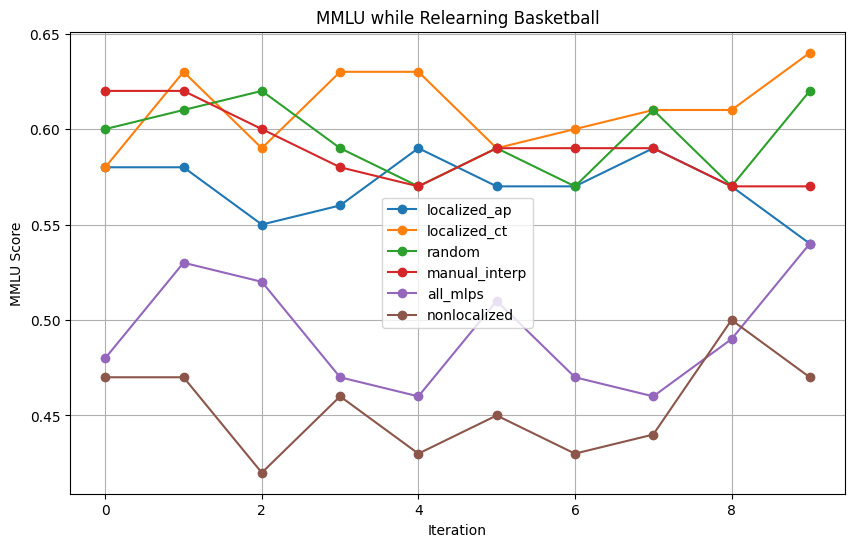

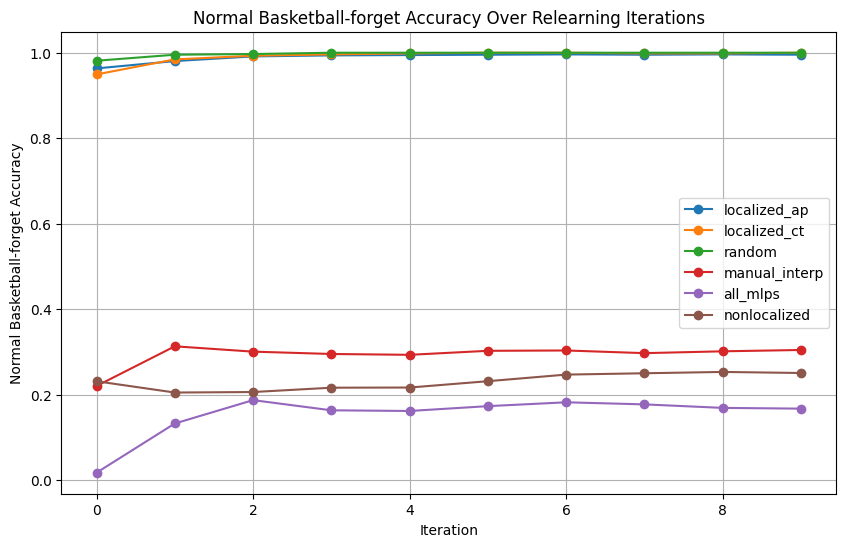

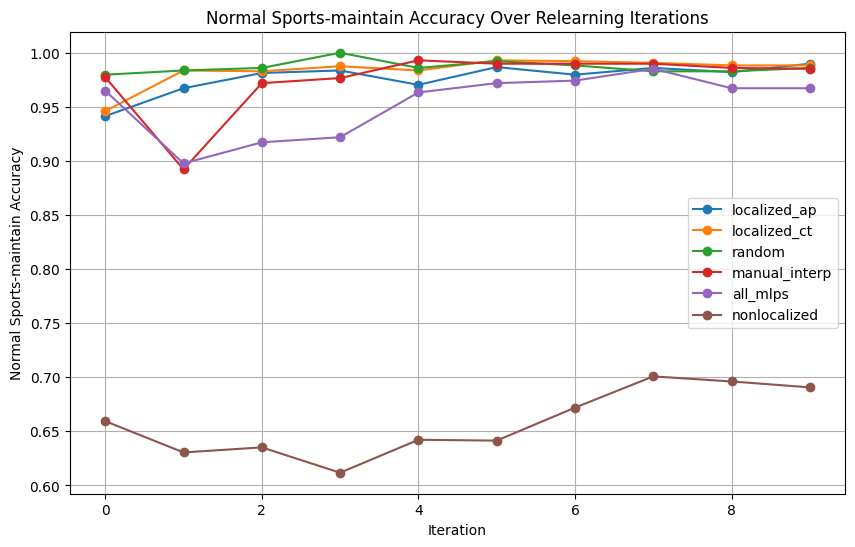

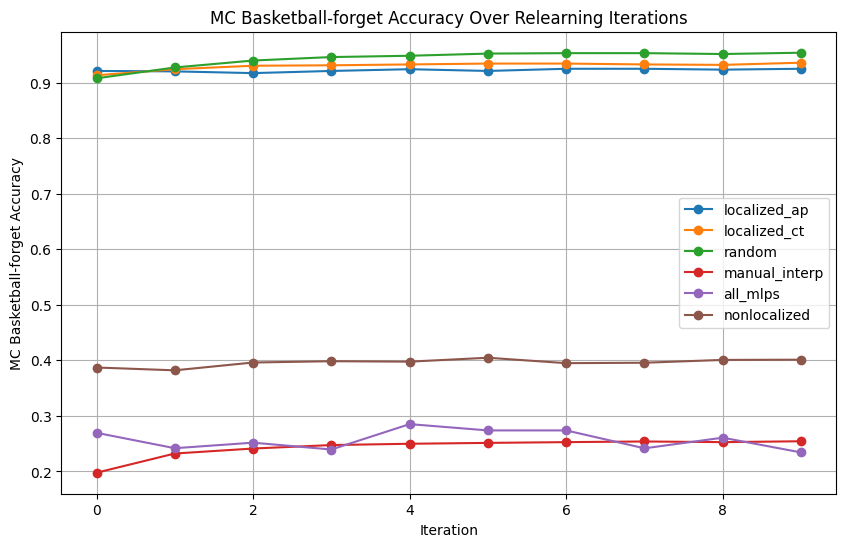

In [ ]:
import matplotlib.pyplot as plt

# Function to plot relearning results
def plot_relearning_results(relearning_test_results, metric, title, ylabel):
    plt.figure(figsize=(10, 6))
    for name, results in relearning_test_results.items():
        values = [result[metric] if metric != 'adversarial' else result[metric]['Normal']['forget'] for result in results]
        plt.plot(range(len(values)), values, label=name, marker='o')
    plt.xlabel('Iteration')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot MMLU
plot_relearning_results(relearning_test_results, 'MMLU', 'MMLU while Relearning Basketball', 'MMLU Score')

# Plot adversarial-normal-forget
def plot_adversarial_results(relearning_test_results, adversarial_type, forget_or_maintain, title, ylabel):
    plt.figure(figsize=(10, 6))
    for name, results in relearning_test_results.items():
        values = [result['adversarial'][adversarial_type][forget_or_maintain] for result in results]
        plt.plot(range(len(values)), values, label=name, marker='o')
    plt.xlabel('Iteration')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot adversarial-normal-forget
plot_adversarial_results(relearning_test_results, 'Normal', 'forget', 'Normal Basketball-forget Accuracy Over Relearning Iterations', 'Normal Basketball-forget Accuracy')

# Plot adversarial-normal-maintain
plot_adversarial_results(relearning_test_results, 'Normal', 'maintain', 'Normal facts-maintain Accuracy Over Relearning Iterations', 'Normal facts-maintain Accuracy')

# Plot adversarial-mc-forget
plot_adversarial_results(relearning_test_results, 'MC', 'forget', 'MC Basketball-forget Accuracy Over Relearning Iterations', 'MC Basketball-forget Accuracy')



In [ ]:
os.makedirs(f"{save_dir}/results", exist_ok=True)
with open(f"{save_dir}/results/relearning_{n_relearn_athletes=}_{n_relearn_iters=}_{model_type}_{combine_heads=}_{beta=}_unlearn_{forget_fact=}_{forget_athletes=}_results.pkl", "wb") as f:
    pickle.dump({"relearning_regular_results": relearning_regular_results, "relearning_adversarial_results": relearning_adversarial_results, "relearning_side_effect_results": relearning_side_effect_results, "relearning_train_results": relearning_train_results, "relearning_test_results": relearning_test_results}, f)

In [ ]:
n_relearn_athletes = 2
n_relearn_iters = 10
model_type = "gemma"
# combine_heads = False
beta = 3

with open(f"{save_dir}/results/relearning_{n_relearn_athletes=}_{n_relearn_iters=}_{model_type}_{combine_heads=}_{beta=}_unlearn_{forget_fact=}_{forget_athletes=}_results.pkl", "rb") as f:
    results = pickle.load(f)
    relearning_regular_results = results['relearning_regular_results']
    relearning_adversarial_results = results['relearning_adversarial_results']
    relearning_side_effect_results = results['relearning_side_effect_results']


In [ ]:
relearning_regular_results

{'localized_ap': {'forget_sport_ce': 0.002783966064453125,
  'forget_sport_acc': 0.998828125,
  'maintain_sports_ce': 0.06891403198242188,
  'maintain_sports_acc': 0.99140625},
 'localized_ct': {'forget_sport_ce': 0.0036376953125,
  'forget_sport_acc': 0.999609375,
  'maintain_sports_ce': 0.03251953125,
  'maintain_sports_acc': 0.9828125},
 'random': {'forget_sport_ce': 0.0003566741943359375,
  'forget_sport_acc': 1.0,
  'maintain_sports_ce': 0.048969268798828125,
  'maintain_sports_acc': 0.989453125},
 'manual_interp': {'forget_sport_ce': 5.30625,
  'forget_sport_acc': 0.284765625,
  'maintain_sports_ce': 0.07118072509765624,
  'maintain_sports_acc': 0.9875},
 'all_mlps': {'forget_sport_ce': 6.39375,
  'forget_sport_acc': 0.1892578125,
  'maintain_sports_ce': 0.0438751220703125,
  'maintain_sports_acc': 0.966015625},
 'nonlocalized': {'forget_sport_ce': 2.5234375,
  'forget_sport_acc': 0.3515625,
  'maintain_sports_ce': 0.176513671875,
  'maintain_sports_acc': 0.900390625}}

In [ ]:
relearning_adversarial_results

{'localized_ap': {'Normal': {'forget': 0.99609375,
   'maintain': 0.9781249999999999},
  'MC': {'forget': 0.9234375000000001, 'maintain': 0.90859375}},
 'localized_ct': {'Normal': {'forget': 0.9984375000000001,
   'maintain': 0.98125},
  'MC': {'forget': 0.9359375000000001, 'maintain': 0.9265625}},
 'random': {'Normal': {'forget': 1.0, 'maintain': 0.9945312500000001},
  'MC': {'forget': 0.95390625, 'maintain': 0.94296875}},
 'manual_interp': {'Normal': {'forget': 0.294140625, 'maintain': 0.98515625},
  'MC': {'forget': 0.25390625, 'maintain': 0.6156250000000001}},
 'all_mlps': {'Normal': {'forget': 0.17207031250000002, 'maintain': 0.9765625},
  'MC': {'forget': 0.266015625, 'maintain': 0.2177734375}},
 'nonlocalized': {'Normal': {'forget': 0.24453125, 'maintain': 0.73671875},
  'MC': {'forget': 0.388671875, 'maintain': 0.337890625}}}

## Latent Knowledge

In [ ]:
# # combine_heads = False
# model_paths_dict = {
#     localization_type: f"{save_dir}/models/{model_type}_{localization_type}_{combine_heads=}_{beta=}_unlearn_{forget_fact=}_{forget_athletes=}.pt" for localization_type in localization_types
# }
# def model_init_and_load_func(mask_type):
#     model_path = model_paths_dict[mask_type]
#     def get_model_fn():
#         model = AutoModelForCausalLM.from_pretrained("google/gemma-7b", torch_dtype=torch.bfloat16)
#         model.load_state_dict(torch.load(model_path))
#         return model
#     return get_model_fn
# model_init_and_load_funcs = {mask_type: model_init_and_load_func(mask_type) for mask_type in localization_types}

In [ ]:
model.cpu()
tl_model = HookedTransformer.from_pretrained(
    model_name_or_path,
    device='cuda',
    default_padding_side="left",
    fold_ln=False,
    fold_value_biases=False,
    center_writing_weights=False,
    dtype=torch.bfloat16,
    hf_model=model
)
tl_tokenizer = tl_model.tokenizer
torch.cuda.memory_allocated() // 1024**3

Loaded pretrained model google/gemma-2-9b into HookedTransformer


21

In [ ]:
# model.cuda()
# left_tokenizer = AutoTokenizer.from_pretrained("google/gemma-2-9b")
# left_tokenizer.pad_token_id = left_tokenizer.eos_token_id
# left_tokenizer.padding_side = "left"
# tokenized = left_tokenizer(["test test test", "blah blah blah", "Fact: Tiger Woods played the fact of"], return_tensors="pt", padding=True)

# hf_model_output = model(**{x: tokenized[x].cuda() for x in tokenized})
# model.cpu()

# tokenized = tl_tokenizer(["test test test", "blah blah blah", "Fact: Tiger Woods played the fact of"], return_tensors="pt", padding=True)
# tl_model_output = tl_model(tokenized.input_ids.cuda(), attention_mask=tokenized.attention_mask.cuda())

# print((tl_model_output[-1] - hf_model_output.logits[-1]).abs().mean())

# print(maintain_facts_eval.get_test_accuracy(tl_model))
# print(forget_fact_eval.get_test_accuracy(tl_model))
print(torch.cuda.memory_allocated() // 1024**3)

21


In [ ]:
# left_tokenizer = AutoTokenizer.from_pretrained("google/gemma-2-9b")
# left_tokenizer.pad_token_id = left_tokenizer.eos_token_id
# left_tokenizer.padding_side = "left"

# from collections import defaultdict
# def layer_hook_function(layer, outputs, last_token_only=True, store_cpu=False):
#     def hook_fn(module, input, output):
#         print(layer, output[0].shape, output[0].isnan().float().mean(axis=-1), output)
#         if isinstance(output, tuple):
#             save_output = output[0].clone().detach()
#         else:
#             save_output = output.clone().detach()
#         if last_token_only:
#             save_output = save_output[:, -1]
#         if store_cpu:
#             save_output = save_output.cpu()
#         outputs[layer].append(save_output)
#         # return output
#     return hook_fn

# def get_hf_residuals(texts, model, batch_size, last_token_only=True, layers_module=None, store_cpu=True, text_col="prompt", return_output=False):
#     # needs left_
#     outputs = defaultdict(list)
#     hooks = []
#     if layers_module is None:
#         layers_module = model.model.layers
#     for layer, block in enumerate(layers_module):
#         hook_fn = layer_hook_function(layer, outputs=outputs, last_token_only=last_token_only, store_cpu=store_cpu)
#         hook_applied = block.register_forward_hook(hook_fn)
#         hooks.append(hook_applied)

#     for idx in tqdm(range(0, len(texts), batch_size)):
#         batch_texts = texts[idx:idx+batch_size]
#         tokenized = left_tokenizer(batch_texts, return_tensors="pt", padding=True)
#         tokenized = {k: v.cuda() for k, v in tokenized.items()}
#         with torch.no_grad():
#             model_output = model(**tokenized)
    
#     for layer in outputs:
#         outputs[layer] = torch.cat(outputs[layer], dim=0)
#         if store_cpu:
#             outputs[layer] = outputs[layer].cpu()

#     for hook in hooks:
#         hook.remove()
    
#     if return_output:
#         return outputs, model_output
#     else:
#         return outputs

def get_tl_residuals(texts, model, batch_size, store_cpu=True, return_outputs=False):
    caches = defaultdict(list)
    for i in tqdm(range(0, len(texts), batch_size)):
        batch_texts = texts[i:i+batch_size]
        tokenized = tl_tokenizer(batch_texts, return_tensors="pt", padding=True)
        outputs = []
        with torch.no_grad():
            _, cache = model.run_with_cache(
                tokenized.input_ids.cuda(),
                attention_mask=tokenized.attention_mask.cuda(),
                names_filter = (lambda name: f"hook_resid_post" in name)
            )
            if return_outputs:
                outputs.append(cache)
        for k, v in cache.items():
            key_layer = int(k.split(".")[1])
            if store_cpu:
                caches[key_layer].append(v[:, -1, :].cpu())
            else:
                caches[key_layer].append(v[:, -1, :])
    for k, v in caches.items():
        caches[k] = torch.cat(v, dim=0)
    if return_outputs:
        return caches, outputs
    else:
        return caches

In [ ]:
# model.cuda()
# sample_resids, sample_output = get_hf_residuals(["test test test", "blah blah blah blasdhf"], model, batch_size=2, return_output=True)
# sample_output.logits
# tokenized = tokenizer(["test test test", "blah blah blah blah"], return_tensors="pt", padding=True)

# model(**{x: tokenized[x].cuda() for x in tokenized})

In [ ]:
batch_size = 16
def get_resids(facts_task, model):
    # train_outputs = get_hf_residuals(facts_task.train_df["prompt"].tolist(), model, batch_size, last_token_only=True) # needs to not be last token only because of layernorm
    # test_outputs = get_hf_residuals(facts_task.test_df["prompt"].tolist(), model, batch_size, last_token_only=True)
    train_outputs = get_tl_residuals(facts_task.train_df["prompt"].tolist(), tl_model, batch_size)
    test_outputs = get_tl_residuals(facts_task.test_df["prompt"].tolist(), tl_model, batch_size)

    train_labels = facts_task.train_df['fact'].tolist()
    test_labels = facts_task.test_df['fact'].tolist()
    return train_outputs, test_outputs, train_labels, test_labels

forget_is_split = True if forget_fact is not None else False
if forget_is_split:
    forget_train_outputs_dict = {}
    forget_test_outputs_dict = {}
    forget_train_labels_dict = {}
    forget_test_labels_dict = {}
else:
    forget_outputs_dict = {}
    forget_labels_dict = {}

maintain_train_outputs_dict = {}
maintain_test_outputs_dict = {}
maintain_train_labels_dict = {}
maintain_test_labels_dict = {}

# for model_name in model_init_and_load_funcs:
    # model = model_init_and_load_funcs[model_name]()
for model_name in trained_models:
    model = trained_models[model_name]
    model.cuda()
    if forget_is_split:
        forget_train_outputs_dict[model_name], forget_test_outputs_dict[model_name], forget_train_labels_dict[model_name], forget_test_labels_dict[model_name] = get_resids(forget_fact_eval, model)
    else:
        forget_outputs_dict[model_name], _, forget_labels_dict[model_name], _ = get_resids(forget_fact_eval, model)
    maintain_train_outputs_dict[model_name], maintain_test_outputs_dict[model_name], maintain_train_labels_dict[model_name], maintain_test_labels_dict[model_name] = get_resids(maintain_facts_eval, model)

    model.cpu()

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
maintain_test_outputs_dict["nonlocalized"][41].shape

torch.Size([310, 3584])

In [ ]:
# set train and test splits
if not forget_is_split:
    print("Performing manual split of the unsplit training dataset")
    train_test_split = .5
    forget_train_outputs_dict = {}
    forget_test_outputs_dict = {}
    forget_train_labels_dict = {}
    forget_test_labels_dict = {}
    # for model_name in model_init_and_load_funcs:
    for model_name in forget_labels_dict:
        num_train = int(len(forget_labels_dict[model_name]) * train_test_split)
        forget_train_labels_dict[model_name] = forget_labels_dict[model_name][:num_train]
        forget_test_labels_dict[model_name] = forget_labels_dict[model_name][num_train:]
        forget_train_outputs_dict[model_name] = {}
        forget_test_outputs_dict[model_name] = {}
        for layer in range(n_layers):
            forget_train_outputs_dict[model_name][layer] = forget_outputs_dict[model_name][layer][:num_train]
            forget_test_outputs_dict[model_name][layer] = forget_outputs_dict[model_name][layer][num_train:]


Performing manual split of the unsplit training dataset


In [ ]:
# for i in range(n_layers):
#     print(f"On layer {i}, AP == CT activations is: {(forget_train_outputs_dict['localized_ap'][i] == forget_train_outputs_dict['localized_ct'][i]).all()}")

###  Approach 1: test probes on forget data and maintain data separately?
not really sure what I did here, but it should generalize to individual athletes

In [ ]:
from sklearn.linear_model import LogisticRegression

def get_fact_labels(string_labels, return_np=True):
    # want three different lists of labels, one for each fact
    facts = ["baseball", "football", "basketball"]
    fact_labels = {fact: [] for fact in facts}
    for label in string_labels:
        for fact in facts:
            if fact in label:
                fact_labels[fact].append(1)
            else:
                fact_labels[fact].append(0)
    if return_np:
        for fact in facts:
            fact_labels[fact] = np.array(fact_labels[fact])
        
    assert sum(fact_labels["baseball"]) + sum(fact_labels["football"]) + sum(fact_labels["basketball"]) == len(string_labels)
    # assert each position always adds up to 1
    for i in range(len(string_labels)):
        assert fact_labels["baseball"][i] + fact_labels["football"][i] + fact_labels["basketball"][i] == 1
    return fact_labels

# train probes
all_probes = defaultdict(dict) # double-nested dictionary, first keys are model_name, second keys are layers, final values are dictionaries with keys "basketball", "football", "baseball" and values of probes

all_train_accs = defaultdict(dict)
all_test_accs = defaultdict(dict)
all_forget_accs = defaultdict(dict)
all_maintain_accs = defaultdict(dict)

combine_accuracies = True

shuffle_train = True
for model_name in tqdm(forget_labels_dict):
    # train_acts = {}

    forget_test_acts = forget_test_outputs_dict[model_name]
    forget_test_labels = get_fact_labels(forget_test_labels_dict[model_name])
    maintain_test_acts = maintain_test_outputs_dict[model_name]
    maintain_test_labels = get_fact_labels(maintain_test_labels_dict[model_name])

    forget_train_acts = forget_train_outputs_dict[model_name]
    maintain_train_acts = maintain_train_outputs_dict[model_name]
    # forget_test_labels_dict[model_name] + maintain_test_labels_dict[model_name]
    train_labels = forget_train_labels_dict[model_name] + maintain_train_labels_dict[model_name]
    train_labels = get_fact_labels(train_labels)

    test_labels = forget_test_labels_dict[model_name] + maintain_test_labels_dict[model_name]
    test_labels = get_fact_labels(test_labels)

    if shuffle_train:
        shuffle_idx = torch.randperm(len(list(train_labels.values())[0]))

    if shuffle_train:
        for fact in train_labels:
            train_labels[fact] = train_labels[fact][shuffle_idx]
    
    # print(f"Labels look like {train_labels}")

    for layer in range(n_layers):
        layer_train_acts = torch.cat([forget_train_acts[layer], maintain_train_acts[layer]], dim=0).float().cpu().numpy()
        layer_test_acts = torch.cat([forget_test_acts[layer], maintain_test_acts[layer]], dim=0).float().cpu().numpy()
        layer_forget_test_acts = forget_test_acts[layer].float().cpu().numpy()
        layer_maintain_test_acts = maintain_test_acts[layer].float().cpu().numpy()

        if shuffle_train:
            layer_train_acts = layer_train_acts[shuffle_idx]
        all_probes[model_name][layer] = {}

        if not combine_accuracies:
            all_train_accs[model_name][layer] = {}
            all_test_accs[model_name][layer] = {}
            all_forget_accs[model_name][layer] = {}
            all_maintain_accs[model_name][layer] = {}

        facts_train_preds = {}
        facts_test_preds = {}
        facts_forget_preds = {}
        facts_maintain_preds = {}
        for fact in train_labels:
            if sum(train_labels[fact]) <= 0:
                print("No labels for fact", fact)
                continue
            probe = LogisticRegression(max_iter=10000)
            # print(f"Training probe for {fact} at layer {layer}, {layer_train_acts.shape=}, {train_labels[fact].shape=}, {train_labels[fact].mean()=}")
            probe.fit(layer_train_acts, train_labels[fact])
            all_probes[model_name][layer][fact] = probe

            # test probes
            # print(f"{fact=}, {layer_train_acts.shape=}, {train_labels[fact].shape=}, {train_labels[fact].mean()=}")
            train_preds = probe.predict(layer_train_acts)
            if not combine_accuracies:
                train_acc = (train_preds == train_labels[fact]).sum() / len(train_labels[fact])
                all_train_accs[model_name][layer][fact] = train_acc
            else:
                facts_train_preds[fact] = train_preds


            # print(f"Testing probe for {fact} at layer {layer}, {layer_test_acts.shape=}, {test_labels[fact].shape=}, {test_labels[fact].mean()=}")
            test_preds = probe.predict(layer_test_acts)
            if not combine_accuracies:
                test_acc = (test_preds == test_labels[fact]).sum() / len(test_labels[fact])
                all_forget_accs[model_name][layer][fact] = test_acc
            else:
                facts_test_preds[fact] = test_preds

            # print(f"{fact=}, {layer_forget_test_acts.shape=}, {forget_test_labels[fact].shape=}, {forget_test_labels[fact].mean()=}")
            forget_test_preds = probe.predict(layer_forget_test_acts)
            if not combine_accuracies:
                forget_acc = (forget_test_preds == forget_test_labels[fact]).sum() / len(forget_test_labels[fact])
                all_test_accs[model_name][layer][fact] = forget_acc
            else:
                facts_forget_preds[fact] = forget_test_preds

            # print(f"{fact=}, {layer_maintain_test_acts.shape=}, {maintain_test_labels[fact].shape=}, {maintain_test_labels[fact].mean()=}")
            maintain_test_preds = probe.predict(layer_maintain_test_acts)
            if not combine_accuracies:
                maintain_acc = (maintain_test_preds == maintain_test_labels[fact]).sum() / len(maintain_test_labels[fact])
                all_maintain_accs[model_name][layer][fact] = maintain_acc 
            else:
                facts_maintain_preds[fact] = maintain_test_preds

        if combine_accuracies:
            # combine accuracies by saying probes correct if all facts are correct
            train_correct = np.ones(len(train_labels["baseball"]))
            test_correct = np.ones(len(test_labels["baseball"]))
            forget_correct = np.ones(len(forget_test_labels["baseball"]))
            maintain_correct = np.ones(len(maintain_test_labels["baseball"]))
            for fact in train_labels:
                if sum(train_labels[fact]) > 0:
                    train_correct *= (facts_train_preds[fact] == train_labels[fact])
                else:
                    print("No train labels for fact", fact)
                if sum(test_labels[fact]) > 0:
                    test_correct *= (facts_test_preds[fact] == test_labels[fact])
                else:
                    print("No test labels for fact", fact)
                if sum(forget_test_labels[fact]) > 0:
                    forget_correct *= (facts_forget_preds[fact] == forget_test_labels[fact])
                else:
                    print("No forget labels for fact", fact)
                if sum(maintain_test_labels[fact]) > 0:
                    maintain_correct *= (facts_maintain_preds[fact] == maintain_test_labels[fact])
                else:
                    print("No maintain labels for fact", fact)

            all_train_accs[model_name][layer] = train_correct.mean()
            all_test_accs[model_name][layer] = test_correct.mean()
            all_forget_accs[model_name][layer] = forget_correct.mean()
            all_maintain_accs[model_name][layer] = maintain_correct.mean()

with open(f"{save_dir}/results/probes_{model_type}_{combine_heads=}_{beta=}_unlearn_{forget_fact=}_{forget_athletes=}.pkl", "wb") as f:
    pickle.dump({"all_probes": all_probes, "all_train_accs": all_train_accs, "all_test_accs": all_test_accs, "all_forget_accs": all_forget_accs, "all_maintain_accs": all_maintain_accs}, f)

  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
# for i in range(n_layers):
#     print(f"At layer {i}, {(all_probes['localized_ap'][i]['basketball'].coef_ - all_probes['localized_ct'][i]['basketball'].coef_).sum()}")

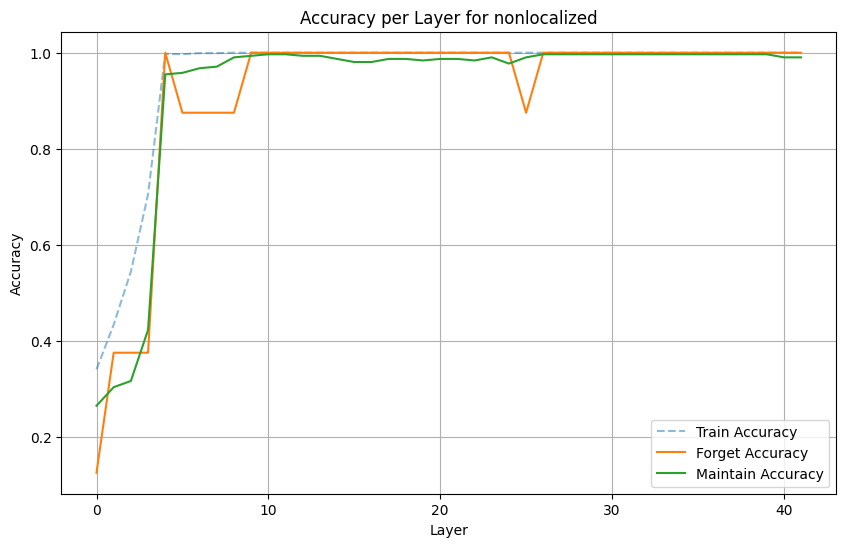

In [ ]:
import matplotlib.pyplot as plt
# combine_heads = False #accidentally set this earlier, but its not actually False in the models
with open(f"{save_dir}/results/probes_{model_type}_{combine_heads=}_{beta=}_unlearn_{forget_fact=}_{forget_athletes=}.pkl", "rb") as f:
    results = pickle.load(f)
    all_probes = results['all_probes']
    all_train_accs = results['all_train_accs']
    all_test_accs = results['all_test_accs']
    all_forget_accs = results['all_forget_accs']
    all_maintain_accs = results['all_maintain_accs']

# combine_accuracies = True
if combine_accuracies:
    def plot_accuracies(all_train_accs, all_test_accs, all_forget_accs, all_maintain_accs):
        for model_name in all_train_accs.keys():
            layers = list(all_train_accs[model_name].keys())
            train_accs = [all_train_accs[model_name][layer] for layer in layers]
            test_accs = [all_test_accs[model_name][layer] for layer in layers]
            forget_accs = [all_forget_accs[model_name][layer] for layer in layers]
            maintain_accs = [all_maintain_accs[model_name][layer] for layer in layers]

            plt.figure(figsize=(10, 6))
            plt.plot(layers, train_accs, label='Train Accuracy', alpha=0.5, linestyle='--')
            # plt.plot(layers, test_accs, label='Test Accuracy')
            plt.plot(layers, forget_accs, label='Forget Accuracy')
            plt.plot(layers, maintain_accs, label='Maintain Accuracy')
            
            plt.xlabel('Layer')
            plt.ylabel('Accuracy')
            plt.title(f'Accuracy per Layer for {model_name}')
            plt.legend()
            plt.grid(True)
            plt.show()

    # Call the function to plot the accuracies
    plot_accuracies(all_train_accs, all_test_accs, all_forget_accs, all_maintain_accs)

else:
    def plot_accuracies(all_train_accs, all_test_accs):
        facts = ["baseball", "football", "basketball"]
        
        for model_name in all_train_accs.keys():
            layers = list(all_train_accs[model_name].keys())
            
            plt.figure(figsize=(12, 8))
            
            for fact in facts:
                train_accs = [all_train_accs[model_name][layer].get(fact, 0) for layer in layers]
                test_accs = [all_test_accs[model_name][layer].get(fact, 0) for layer in layers]
                # forget_accs = [all_forget_accs[model_name][layer].get(fact, 0) for layer in layers]
                # maintain_accs = [all_maintain_accs[model_name][layer].get(fact, 0) for layer in layers]
                
                plt.plot(layers, train_accs, label=f'Train Accuracy - {fact}', linestyle='--', alpha=0.5)
                plt.plot(layers, test_accs, label=f'Test Accuracy - {fact}')
                # plt.plot(layers, forget_accs, label=f'Forget Accuracy - {fact}')
                # plt.plot(layers, maintain_accs, label=f'Maintain Accuracy - {fact}')
            
            plt.xlabel('Layer')
            plt.ylabel('Accuracy')
            plt.title(f'Accuracy per Layer for {model_name}')
            plt.legend()
            plt.grid(True)
            plt.show()

    # Call the function to plot the accuracies
    plot_accuracies(all_train_accs, all_test_accs)

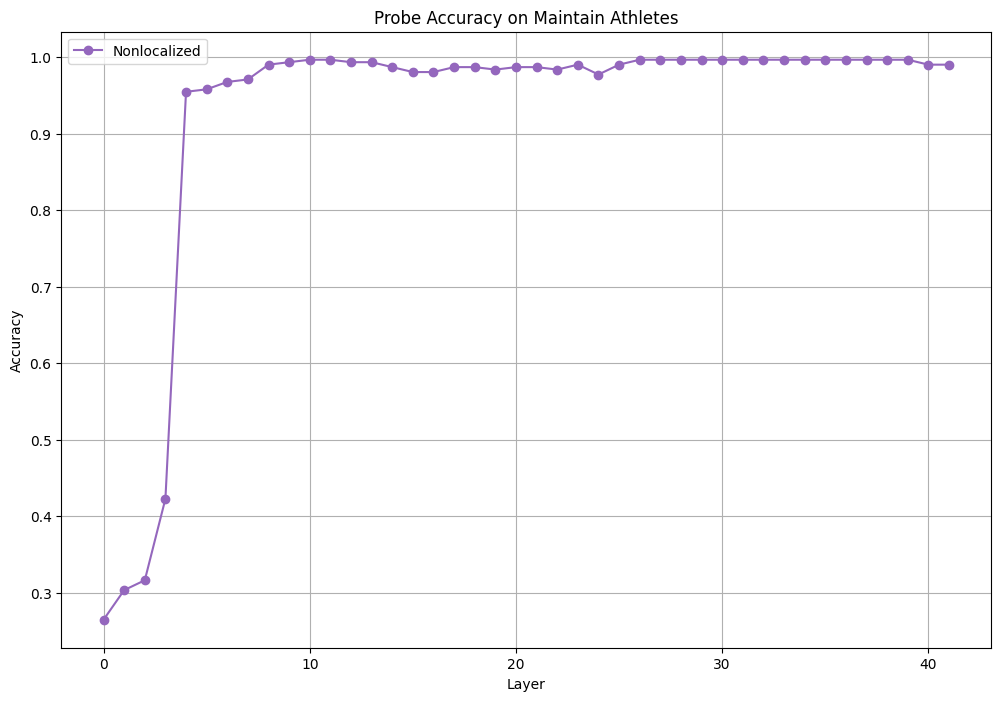

In [ ]:
import matplotlib.pyplot as plt

def plot_final_accuracies(all_accs, formal=True):
    # colors = plt.cm.get_cmap('tab10', len(all_train_accs))  # Get a colormap with enough colors for all models

    plt.figure(figsize=(12, 8))
    
    for idx, model_name in enumerate(all_train_accs.keys()):
        layers = list(all_train_accs[model_name].keys())
        accs = [all_accs[model_name][layer] for layer in layers]

        # plt.plot(layers, train_accs, label=f'{model_name} Train', color=colors(idx), linestyle=line_styles[0], alpha=0.5)
        # plt.plot(layers, forget_accs, label=f'{model_name} Forget', color=colors[idx], linestyle=line_styles[1])
        plt.plot(layers, accs, label=f'{formal_name_dict[model_name]}', color=color_map[model_name], marker='o')
    
    plt.xlabel('Layer')
    plt.ylabel('Accuracy')

# Call the function to plot the accuracies
plot_final_accuracies(all_maintain_accs)
plt.title('Probe Accuracy on Maintain Athletes')
plt.legend()
plt.grid(True)
plt.show()


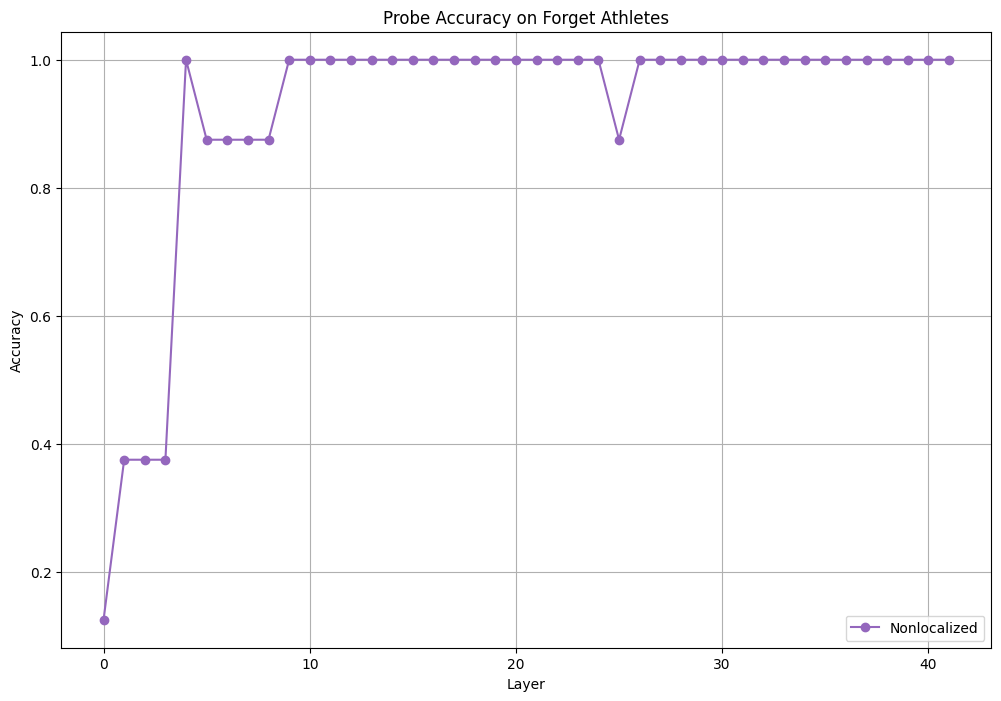

In [ ]:
plot_final_accuracies(all_forget_accs)
plt.title('Probe Accuracy on Forget Athletes')
plt.legend()
plt.grid(True)
plt.show()

## Upload models to Huggingface

In [ ]:
from dotenv import load_dotenv
import os 

load_dotenv()
hf_access_token = os.getenv("HUGGINGFACE_API_KEY")

from huggingface_hub import HfApi, create_repo
api = HfApi()

# for folder_path in ["localized_finetuning_16_athletes", "localized_finetuning_basketball", "localized_finetuning_injection_16_athletes", "localized_finetuning_injection_basketball"]:
for folder_path in ["localized_finetuning_injection_16_athletes", "localized_finetuning_injection_basketball"]:
    finetuning_type = folder_path[21:]
    print(f"Saving from results/{folder_path} to PhillipGuo/mech_unlearning_gemma7b_{finetuning_type}")
    create_repo(f"PhillipGuo/mech_unlearning_gemma7b_{finetuning_type}", token=hf_access_token, exist_ok=True)
    api.upload_folder(
        folder_path=f"results/{folder_path}",        
        repo_id=f"PhillipGuo/mech_unlearning_gemma7b_{finetuning_type}",
        # repo_type="space",
        token=hf_access_token,
        multi_commits=True,
        multi_commits_verbose=True,
    )

Saving from results/localized_finetuning_injection_16_athletes to PhillipGuo/mech_unlearning_gemma7b_injection_16_athletes


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/utils/_experimental.py:58: UserWarning: 'plan_multi_commits' is experimental and might be subject to breaking changes in the future. You can disable this warning by setting `HF_HUB_DISABLE_EXPERIMENTAL_WARNING=1` as environment variable.
  warnings.warn(
/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/huggingface_hub/utils/_experimental.py:58: UserWarning: 'HfApi.create_commits_on_pr' is experimental and might be subject to breaking changes in the future. You can disable this warning by setting `HF_HUB_DISABLE_EXPERIMENTAL_WARNING=1` as environment variable.
  warnings.warn(
Will create 0 deletion commit(s) and 7 addition commit(s), totalling 16 atomic operations.
Multi-commits strategy with ID f2d34c0ea5a095db9342b80cd7366dcacebaa7f27c0b7f38a958926f82c03bff.
PR already exists: https://huggingface.co/PhillipGuo/mech_unlearning_gemma7b_injection_16_athletes/discussions/1. Will resum

gemma_nonlocalized_combine_heads=True_beta=3_unlearn_forget_sport=None_forget_athletes=16.pt:   0%|          |…

  step eecf9d0ce7d4ce515aa1d9ecba310b1171689d14a8edae98bb64bc8dfe372127 completed (still 2 to go).


gemma_random_combine_heads=True_beta=3_unlearn_forget_sport=None_forget_athletes=16.pt:   0%|          | 0.00/…

  step 9e3198da218a70494b4c01214f5a9f01c1b7cb8a2066ce3a1ac8fefa36b226b4 completed (still 1 to go).


eval_metrics.pkl:   0%|          | 0.00/2.75k [00:00<?, ?B/s]

full_capability_dict.pkl:   0%|          | 0.00/38.4k [00:00<?, ?B/s]

gemma_localized_ap_combine_heads=True_beta=3_unlearn_forget_sport=None_forget_athletes=16_metrics.pkl:   0%|  …

gemma_localized_ct_combine_heads=True_beta=3_unlearn_forget_sport=None_forget_athletes=16_metrics.pkl:   0%|  …

Upload 10 LFS files:   0%|          | 0/10 [00:00<?, ?it/s]

gemma_all_mlps_combine_heads=True_beta=3_unlearn_forget_sport=None_forget_athletes=16_metrics.pkl:   0%|      …

gemma_manual_interp_combine_heads=True_beta=3_unlearn_forget_sport=None_forget_athletes=16_metrics.pkl:   0%| …

gemma_nonlocalized_combine_heads=True_beta=3_unlearn_forget_sport=None_forget_athletes=16_metrics.pkl:   0%|  …

gemma_random_combine_heads=True_beta=3_unlearn_forget_sport=None_forget_athletes=16_metrics.pkl:   0%|        …

probes_gemma_combine_heads=True_beta=3_unlearn_forget_sport=None_forget_athletes=16.pkl:   0%|          | 0.00…

relearning_n_relearn_athletes=2_n_relearn_iters=10_gemma_combine_heads=True_beta=3_unlearn_forget_sport=None_f…

  step 061e4e22ee9f39166ff5daa38c049552ac1c1818fb7d6bd6d65d5796a8b45c39 completed (still 0 to go).
All commits have been pushed.
PR is now open for reviews.
PR has been automatically merged (`merge_pr=True` was passed).


Saving from results/localized_finetuning_injection_basketball to PhillipGuo/mech_unlearning_gemma7b_injection_basketball


Will create 0 deletion commit(s) and 7 addition commit(s), totalling 16 atomic operations.
Multi-commits strategy with ID 7acd7830c09dea54475295018544485429b24b10f2b89c4d9cd459bcf304b016.
New PR created: https://huggingface.co/PhillipGuo/mech_unlearning_gemma7b_injection_basketball/discussions/1


gemma_all_mlps_combine_heads=True_beta=3_unlearn_forget_sport='basketball'_forget_athletes=None.pt:   0%|     …

  step b49df7e4ef2823061769b1dda01efb8255c7393fa2c19471ca0a6dbb1ed35bad completed (still 6 to go).


gemma_localized_ap_combine_heads=True_beta=3_unlearn_forget_sport='basketball'_forget_athletes=None.pt:   0%| …

  step 3b8bd3b0db6d662e22b515d9252d23015f5cd4d7995b6469b3c3e3191a22949d completed (still 5 to go).


gemma_localized_ct_combine_heads=True_beta=3_unlearn_forget_sport='basketball'_forget_athletes=None.pt:   0%| …

  step d5e5a294bccbb596cce342973dbff71623e44d62f0fcd9159a7e9eeba2f919d0 completed (still 4 to go).


gemma_manual_interp_combine_heads=True_beta=3_unlearn_forget_sport='basketball'_forget_athletes=None.pt:   0%|…

  step bc30fa6b78ab5df93350d7de5bd4e4e227af928ceec2e9114d0b1b762176bb7d completed (still 3 to go).


gemma_nonlocalized_combine_heads=True_beta=3_unlearn_forget_sport='basketball'_forget_athletes=None.pt:   0%| …

  step 2e5d95417edd5b97066bff5e4e612c4437f99233bc07a58b4ccacd6a95a19885 completed (still 2 to go).


gemma_random_combine_heads=True_beta=3_unlearn_forget_sport='basketball'_forget_athletes=None.pt:   0%|       …

  step 8993df328c8812ef7168002992a63b12f0e7075c97471eeeb931d17c2285c174 completed (still 1 to go).


Upload 10 LFS files:   0%|          | 0/10 [00:00<?, ?it/s]

gemma_all_mlps_combine_heads=True_beta=3_unlearn_forget_sport='basketball'_forget_athletes=None_metrics.pkl:  …

full_capability_dict.pkl:   0%|          | 0.00/38.4k [00:00<?, ?B/s]

gemma_localized_ap_combine_heads=True_beta=3_unlearn_forget_sport='basketball'_forget_athletes=None_metrics.pk…

gemma_localized_ct_combine_heads=True_beta=3_unlearn_forget_sport='basketball'_forget_athletes=None_metrics.pk…

eval_metrics.pkl:   0%|          | 0.00/2.75k [00:00<?, ?B/s]

gemma_manual_interp_combine_heads=True_beta=3_unlearn_forget_sport='basketball'_forget_athletes=None_metrics.p…

gemma_nonlocalized_combine_heads=True_beta=3_unlearn_forget_sport='basketball'_forget_athletes=None_metrics.pk…

gemma_random_combine_heads=True_beta=3_unlearn_forget_sport='basketball'_forget_athletes=None_metrics.pkl:   0…

probes_gemma_combine_heads=True_beta=3_unlearn_forget_sport='basketball'_forget_athletes=None.pkl:   0%|      …

relearning_n_relearn_athletes=2_n_relearn_iters=10_gemma_combine_heads=True_beta=3_unlearn_forget_sport='baske…

  step 2732acc62cd09ca9252f69e09f8bc0a82f940d5b8b04b226f8d42e96bc808e61 completed (still 0 to go).
All commits have been pushed.
PR is now open for reviews.
PR has been automatically merged (`merge_pr=True` was passed).
